<a href="https://colab.research.google.com/github/gbessardon/AOD_climatology/blob/main/Open_mask_kwabena_scripts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working Environment set-up
Just run everything the good point with google collab we should have the same configuration

Mount google drive
It will ask you to click on a link and copy paste an access code to your google drive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Install basemap

In [ ]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip3 install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
The following packages were automatically installed and are no longer required:
  default-libmysqlclient-dev libarmadillo-dev libarpack2-dev libdap-dev
  libdapserver7v5 libepsilon-dev libfreexl-dev libfyba-dev libgeotiff-dev
  libgif-dev libjson-c-dev libkml-dev libkmlconvenience1 libkmlregionator1
  libkmlxsd1 libminizip-dev libmysqlclient-dev libnetcdf-dev libogdi3.2-dev
  libopenjp2-7-dev libpoppler-dev libpoppler-private-dev libpq-dev libproj-dev
  libqhull-dev libqhull-r7 libspatialite-dev libsqlite3-dev libsuperlu-dev
  liburiparser-dev libwebp-dev libxerces-c-dev unixodbc-dev
Use 'apt 

Install pyproj, pyresample, netCDF4

In [ ]:
!pip3 install pyproj
!pip3 install pyresample
!pip3 install netCDF4

Install pyhdf

In [ ]:
!apt-get install libhdf4-dev
!pip3 install pyhdf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libhdf4-dev is already the newest version (4.2.13-2).
The following packages were automatically installed and are no longer required:
  default-libmysqlclient-dev libarmadillo-dev libarpack2-dev libdap-dev
  libdapserver7v5 libepsilon-dev libfreexl-dev libfyba-dev libgeotiff-dev
  libgif-dev libjson-c-dev libkml-dev libkmlconvenience1 libkmlregionator1
  libkmlxsd1 libminizip-dev libmysqlclient-dev libnetcdf-dev libogdi3.2-dev
  libopenjp2-7-dev libpoppler-dev libpoppler-private-dev libpq-dev libproj-dev
  libqhull-dev libqhull-r7 libspatialite-dev libsqlite3-dev libsuperlu-dev
  liburiparser-dev libwebp-dev libxerces-c-dev unixodbc-dev
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
!pip3 install latex

In [ ]:
!pip3 install rasterio

# PHD_AOD_ave.py

In [ ]:
from pyproj import Proj
import numpy as np
import matplotlib.pyplot as plt
import pyresample as pr
from pyresample import image, geometry
from netCDF4 import Dataset
from pylab import *
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import os
import numpy as np
from pyhdf.SD import SD, SDC
from scipy.interpolate import griddata
from osgeo import gdal

/usr/local/lib/python3.7/dist-packages/pyresample/bilinear/__init__.py:50: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")


In [ ]:
def get_filepaths(directory,string):

    file_paths = []  # List which will store all of the full filepaths.

    # Walk the tree.
    for root, directories, files in os.walk(directory):
        for filename in files:
            # Join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            if string in filepath:
                file_paths.append(filepath)  # Add it to the list.

    return file_paths

def getdataset(fn):
    f = SD(fn, SDC.READ)


    datasets_dic = f.datasets()


    return f,datasets_dic


def getdata(f,varname):
    sds_obj = f.select(varname) #select sds
    data = sds_obj.get() #get sds data
    for key, value in sds_obj.attributes().items():

        if key == 'add_offset':
            add_offset = value
        if key == 'scale_factor':
            scale_factor = value
    data = (data - add_offset) * scale_factor #correct the offset scale factor

    return data

def selectvar(fn):
    f,datasets_dic = getdataset(fn)
    ACFL=getdata(f,'Aerosol_Cloud_Fraction_Land')
    ACFO=getdata(f,'Aerosol_Cloud_Fraction_Ocean')
    longitude=getdata(f,'Longitude')
    latitude=getdata(f,'Latitude')
    CODL=getdata(f,'Optical_Depth_Land_And_Ocean')#'Corrected_Optical_Depth_Land_And_Ocean')#'av2p1')
    temps=getdata(f,'Scan_Start_Time')



    #    n=np.where(CODL==np.min(CODL))
    #    latitude[n]=-500
    #    longitude[n]=-500
    #    nonvalid=0

    return (CODL,longitude,latitude,temps)


def regrid(lonmin,lonmax,latmin,latmax,grids,data,latitude,longitude):

    lat=np.arange(latmin,latmax,grids)
    lon=np.arange(lonmin,lonmax,grids)
    n=np.where(data==np.min(data))
    latitude[n]=-500
    longitude[n]=-500
    datan=np.zeros((len(lat),len(lon)))*np.nan
    for i,la in enumerate(lat):
        a=np.where(np.abs(la-latitude)<grids+0.01)
        if len(a[0])>0:
            for j,lo in enumerate(lon):
                b=np.where(np.abs(lo-longitude[a])<grids+0.01)
                if len(b[0])>0:
                    indlat=a[0][b[0]][0]
                    indlon=a[1][b[0]][0]
                    datan[i][j]=CODL[indlat][indlon]

    return(datan,lat,lon)

def nan_helper(y):


    return np.isnan(y), lambda z: z.nonzero()[0]

In [ ]:
#I change this script then the filepath doesn't matter it just searches for the .A in the filename
def sameday(filepath):
    day=(filepath[0].split('.A')[1].split('.')[0])
    dayoyear=[]
    dayoyear.append(int(filepath[0].split('.A')[1].split('.')[0][4:7]))
    dayindex=[]
    dayindex.append(0)
    for i,fn in enumerate(filepath):
        if not day==int(fn.split('.A')[1].split('.')[0]):
            dayindex.append(i)
            day=int(fn.split('.A')[1].split('.')[0])
            dayoyear.append(int(fn.split('.A')[1].split('.')[0][4:7]))
    dayindex.append(len(filepath))
    return(dayindex,dayoyear)

In [ ]:
lonmin=-3.25
lonmax=1.2
latmin=4.6
latmax=11.2
gridsized=0.04
CODLday=[]
CODLrday=[]
tday=[]
CODLrdecjanfeb=[]
tdecjanfeb=[]
CODLrmaraprmay=[]
tmaraprmay=[]
CODLrjunjulaug=[]
tjunjulaug=[]
CODLrsepoctnov=[]
tsepoctnov=[]

# Prepare mask

In [ ]:
def getyearfiles(maskyearfile,Year): # This open the hdf file and creates a tif file corresponding to MASK and the QA of the MASK
  for f in maskyearfile:
    ds=gdal.Open(f)
    subdatasets = ds.GetSubDatasets()
    MASK_name = subdatasets[0][0]
    MASK = gdal.Open(MASK_name, gdal.GA_ReadOnly)
    QA_name = subdatasets[1][0]
    QA = gdal.Open(QA_name, gdal.GA_ReadOnly)
    #opt=gdal.WarpOptions(srcSRS=MASK.GetProjection(),dstSRS='EPSG:4326')
    mask_fn=f.replace('.hdf','MASK.tif')
    gdal.Warp(mask_fn,MASK)
    qa_fn = f.replace('.hdf','QA.tif')
    gdal.Warp(qa_fn,QA)

In [ ]:
def merge_and_repojectyearfiles(sources,outFileName): # this function merge the 4 year tile and reproject it it to lat/lon
    gdal.Warp('temp.tif',sources)
    ds=gdal.Open('temp.tif')
    gt=ds.GetGeoTransform()
    width=ds.RasterXSize
    height=ds.RasterYSize
    xmin = gt[0]
    ymax = gt[3] + width*gt[4] + height*gt[5]
    xmax = gt[0] + width*gt[1] + height*gt[2]
    ymin = gt[3]


    pr=Proj(ds.GetProjectionRef())
    Xmin,Ymax=pr(gt[0],gt[3],inverse=True)
    Xmax,Ymin=pr(gt[0] + width*gt[1] + height*gt[2],
                gt[3] + width*gt[4] + height*gt[5],
                inverse=True)
    gt1=(Xmax-Xmin)/width
    gt5=(Ymin-Ymax)/height
    GT=(Xmin,gt1,0.0,Ymax,0.0,gt5)
    driver = gdal.GetDriverByName("GTiff")
    outdata = driver.Create(outFileName, ds.RasterXSize, ds.RasterYSize, 1)
    outdata.SetGeoTransform(GT)
    outdata.SetProjection('EPSG:4326')
    outdata.GetRasterBand(1).WriteArray(ds.ReadAsArray())
    outdata.GetRasterBand(1).SetNoDataValue(253)##if you want these values transparent
    outdata.FlushCache() ##saves to disk!!
    outdata = None
    band=None
    ds=None

In [ ]:
!ln -s /content/gdrive/MyDrive/Inland_water

ln: failed to create symbolic link './Inland_water': File exists


In [ ]:
dirnamem = '/content/Inland_water'
filepathm=get_filepaths(dirnamem,'.hdf')

In [ ]:
# Merge the 4 year files and convert to LAT/LON projection
Yearlist=np.arange(2005,2015)
for Y in Yearlist:
  Year=str(Y)
  maskyearfile=[fv8 for fv8 in filepathm if '.A'+Year in fv8]
  getyearfiles(maskyearfile,Year)
  sourcesMASK=[f.replace('.hdf','MASK.tif') for f in sorted(maskyearfile)]
  merge_and_repojectyearfiles(sourcesMASK,'merged'+Year+'MASK.tif')
  sourcesQA=[f.replace('.hdf','QA.tif') for f in sorted(maskyearfile)]
  merge_and_repojectyearfiles(sourcesQA,'merged'+Year+'QA.tif')

In [ ]:
!gdalinfo /content/Inland_water/MOD44W.A2014001.h17v07.006.2018033154358QA.tif

Driver: GTiff/GeoTIFF
Files: /content/Inland_water/MOD44W.A2014001.h17v07.006.2018033154358QA.tif
Size is 4800, 4800
Coordinate System is:
PROJCS["unnamed",
    GEOGCS["Unknown datum based upon the custom spheroid",
        DATUM["Not_specified_based_on_custom_spheroid",
            SPHEROID["Custom spheroid",6371007.181,0]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Sinusoidal"],
    PARAMETER["longitude_of_center",0],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]]]
Origin = (-1111950.519667000044137,2223901.039332999847829)
Pixel Size = (231.656358263854145,-231.656358263854145)
Metadata:
  AREA_OR_POINT=Area
  ASSOCIATEDINSTRUMENTSHORTNAME.1=MODIS
  ASSOCIATEDPLATFORMSHORTNAME.1=Terra
  ASSOCIATEDSENSORSHORTNAME.1=MODIS
  AUTOMATICQUALITYFLAG.1=Passed
  AUTOMATICQUALITYFLAGEXPLANATION.1=set passed as default, will decide later
  DATACOLUMNS=4800
  DATAROWS=480

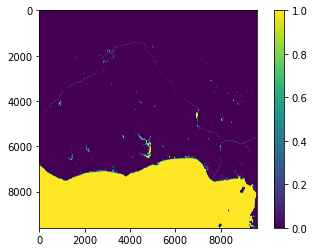

In [ ]:
# Plot the Year 2015 mask
fig=plt.figure()
ax=fig.gca()
im=ax.imshow(gdal.Open('merged'+Year+'MASK.tif').ReadAsArray())
cb = plt.colorbar(im)


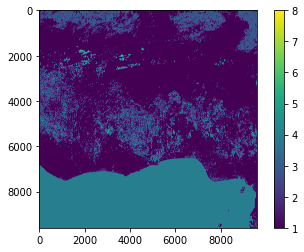

In [ ]:
#Plot the year 2015 QA of the MASK
fig=plt.figure()
ax=fig.gca()
im=ax.imshow(gdal.Open('merged'+Year+'QA.tif').ReadAsArray())
cb = plt.colorbar(im)

In [ ]:
# Sum all the MASK values
sumMASKarray=np.sum(np.array([gdal.Open('merged'+str(Year)+'MASK.tif').ReadAsArray() for Year in Yearlist]),axis=0)/len(Yearlist)

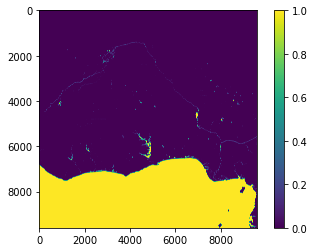

In [ ]:
fig=plt.figure()
ax=fig.gca()
im=ax.imshow(sumMASKarray)
cb = plt.colorbar(im)

In [ ]:
def sortQAvalues(Year,validQAvalues):
  Ar=gdal.Open('merged'+Year+'QA.tif').ReadAsArray()
  Res=Ar*0+1
  for v in validQAvalues:
    Res[np.where(Ar==v)]=0
  return Res


In [ ]:
validQAvalues=[1,3,7,8] #define the qa index we save

  Legend=1: High Confidence Observation
     2: Low Confidence Water, but MOD44W C5 is water
     3: Low Confidence Land
     4: Ocean Mask
     5: Ocean Mask but no water detected
     6: Burn Scar (from MCD64A1)
     7: Urban/Impervious surface
     8: No water detected, Collection 5 shows water
    10: No data (outside of projected area)

In [ ]:
Res=np.sum(np.array([sortQAvalues(str(Year),validQAvalues) for Year in Yearlist]),axis=0)

In [ ]:
QAresmask=np.array((sumMASKarray+Res)==0) #resulting QA mask

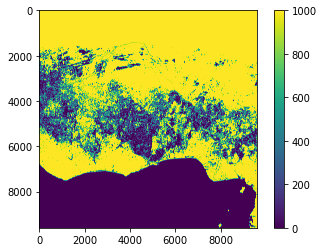

In [ ]:
fig=plt.figure()
ax=fig.gca()
im=ax.imshow(QAresmask*1000)
cb = plt.colorbar(im)

In [ ]:
Xmax,Ymin=pr(gt[0] + width*gt[1] + height*gt[2],
             gt[3] + width*gt[4] + height*gt[5],
             inverse=True)

NameError: ignored

In [ ]:
!gdalinfo test2.tif

In [ ]:
pr=Proj(ds.GetProjectionRef())

In [ ]:
np.median(np.gradient(lat,axis=0))

In [ ]:
np.median(np.gradient(lon,axis=1))

In [ ]:
Year='2015'
maskyearfile=[fv8 for fv8 in filepathm if '.A'+Year in fv8]

In [ ]:
filepathv8=[f for f in filepathm if 'v08.006' in f] # select the version 8

In [ ]:
Year='2015'
maskyearfile=[fv8 for fv8 in filepathv8 if '.A'+Year in fv8]# select the file corresponding to 2015
maskyearhfile=[m for m in maskyearfile if '.h17' in m ][0]# select the h17 file don't know what are these????

In [ ]:
ds=gdal.Open(maskyearhfile[0])
subdatasets = ds.GetSubDatasets()
MASK_name = subdatasets[0][0]
MASK = gdal.Open(MASK_name, gdal.GA_ReadOnly)
QA_name = subdatasets[1][0]
QA = gdal.Open(QA_name, gdal.GA_ReadOnly)
opt=gdal.WarpOptions(dstSRS='EPSG:4326')
                     #outputBounds=(lonmin-(gridsized/2), latmin-(gridsized/2), lonmax+(gridsized/2), latmin+(gridsized/2)))
mask_fn=maskyearhfile.replace('.hdf','MASK.tif')
gdal.Warp(mask_fn,MASK,options=opt)
qa_fn = maskyearhfile.replace('.hdf','QA.tif')
gdal.Warp(qa_fn,QA,options=opt)

In [ ]:
maskyearhfile

In [ ]:
os.remove(mask_fn)

In [ ]:
MASK.GetGeoTransform()

In [ ]:
MASK.GetProjection()

In [ ]:
ds=gdal.Open(mask_fn)
data=ds.ReadAsArray()
ds.GetGeoTransform()

In [ ]:
plt.imshow(data)

In [ ]:
fig = plt.figure(figsize=(40,30))
ax = fig.add_subplot(111)
m =  Basemap(projection='merc',llcrnrlat=latmin,urcrnrlat=latmax,\
           llcrnrlon=lonmin,urcrnrlon=lonmax,lat_ts=1,resolution='f')

nx = int((m.xmax-m.xmin)/(gridsized*100000.))+1; ny = int((m.ymax-m.ymin)/(gridsized*100000.))+1
#nx = int((m.xmax-m.xmin)/(5000.))+1; ny = int((m.ymax-m.ymin)/(5000.))+1
CODLavgt=m.transform_scalar(ODavg,lon,lat,nx,ny)
im=m.imshow(CODLavgt,cmap=plt.cm.YlOrRd,vmin=0,vmax=0.8,)#cmap=plt.cm.jet
m.drawcoastlines()
m.drawcountries(linewidth=4)

kulon = -1.6163
kulat = 6.66666
x,y = m(kulon, kulat)
k=m.plot(x, y, 'ko', markersize=40)
ax.text(x+12000,y-5000,r'Kumasi', fontsize=60,color='black')

Aclon=-0.1870
Aclat=5.6037
#5.6037° N, 0.1870° W
x,y = m(Aclon, Aclat)
k=m.plot(x, y, 'ko', markersize=40)
ax.text(x+12000,y-5000,'Accra', fontsize=60,color='black')

Tamlon=-0.8486
Tamlat=9.4329
#5.6037° N, 0.1870° W
x,y = m(Tamlon, Tamlat)
k=m.plot(x, y, 'ko', markersize=40)
ax.text(x+12000,y-5000,r'Tamale', fontsize=60,color='black')

aerolon=-0.30206
aerolat=6.10941
#5.6037° N, 0.1870° W
x,y = m(aerolon, aerolat)
k=m.plot(x, y, '*k', markersize=40)
ax.text(x+12000,y-5000,r'Aeronet site', fontsize=60,color='black')


Tarlon=-1.7831
Tarlat=4.9016
#5.6037° N, 0.1870° W
x,y = m(Tarlon, Tarlat)
k=m.plot(x, y, 'ko', markersize=40)
ax.text(x+12000,y-5000,r'Takoradi', fontsize=60,color='black')

parallels = np.arange(4,12,2)
m.drawparallels(parallels,labels=[1,0,0,1],fontsize=30)
meridians = np.arange(-5.,8.,2)
m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=30)

##getting the limits of the map:
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
map_edges = np.array([[x0,y0],[x1,y0],[x1,y1],[x0,y1]])

##getting all polygons used to draw the coastlines of the map
polys = [p.boundary for p in m.landpolygons]

##combining with map edges
polys = [map_edges]+polys[:]

##creating a PathPatch
codes = [
    [Path.MOVETO] + [Path.LINETO for p in p[1:]]
    for p in polys
]
polys_lin = [v for p in polys for v in p]
codes_lin = [c for cs in codes for c in cs]
path = Path(polys_lin, codes_lin)
patch = PathPatch(path,facecolor='white', lw=0)

##masking the data:
ax.add_patch(patch)

cb = m.colorbar(im,"right", size="5%", pad='2%')
cb.ax.set_ylabel('$AOD$',fontsize=50)
cb.ax.tick_params(labelsize=50)
ax.set_xlabel('$Latitude (^{o})$',fontsize=50)
ax.set_ylabel('$Longitude (^{o})$',fontsize=50)
ax.tick_params(axis='x', labelsize=50)
ax.tick_params(axis='y', labelsize=50)
ax.xaxis.labelpad = 50
ax.yaxis.labelpad = 50
fig.savefig('AOD_Average_2016.pdf',bbox='tight',transparent=False, format='pdf', dpi=100)

# loop over the dayindex

In [ ]:
dayindex,dayoyear=sameday(filepath)

In [ ]:
filenamenetcdf = 'aqua_aod_ghana_avg_timev2_GB2016_land_ocean.nc'
data_netcdf(filenamenetcdf,CODLravg,CODLrstd,CODLrday,CODLrdecjanfebavg,CODLrdecjanfebstd,CODLrmaraprmayavg,CODLrmaraprmaystd,CODLrjunjulaugavg,CODLrjunjulaugstd,CODLrsepoctnovavg,CODLrsepoctnovstd,lat,lon,tday)

# my_try_AOD_PHD.py

In [ ]:
import numpy as np
# LatLon with WGS84 datum used by GPS units and Google Earth
import matplotlib.pyplot as plt
import pyresample as pr
from pyresample import image, geometry
from netCDF4 import Dataset
from pylab import *
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import os
# from matplotlib import rc
import numpy as np
from mpl_toolkits.basemap import addcyclic
from pyhdf.SD import SD, SDC
from scipy.interpolate import griddata
from geopy.distance import great_circle
import xarray as xr
from matplotlib.patches import Path, PathPatch
from matplotlib import rc, rcParams
import latex

In [ ]:
def get_filepaths(directory,string):

    file_paths = []  # List which will store all of the full filepaths.

    # Walk the tree.
    for root, directories, files in os.walk(directory):
        for filename in files:
            # Join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            if string in filepath:
                file_paths.append(filepath)  # Add it to the list.

    return file_paths




def regrid(lonmin,lonmax,latmin,latmax,grids,data,latitude,longitude):

    lat=np.arange(latmin,latmax,grids)
    lon=np.arange(lonmin,lonmax,grids)
    n=np.where(data==np.min(data))
    latitude[n]=-500
    longitude[n]=-500
   # nonvalid=0
    datan=np.zeros((len(lat),len(lon)))*np.nan
    for i,la in enumerate(lat):
        a=np.where(np.abs(la-latitude)<grids+0.01)
        if len(a[0])>0:
            for j,lo in enumerate(lon):
                b=np.where(np.abs(lo-longitude[a])<grids+0.01)
                if len(b[0])>0:
                    indlat=a[0][b[0]][0]
                    indlon=a[1][b[0]][0]
                    datan[i][j]=CODL[indlat][indlon]

    return(datan,lat,lon)

In [ ]:
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

In [ ]:
def opennetcdfprofiles(fn):
    dataset=Dataset(fn)
    ODavg= dataset.variables['optical_depth_avg'][:]
    ODstd= dataset.variables['optical_depth_std'][:]
    ODday= dataset.variables['optical_depth_day'][:]
    #ODjunjul=dataset.variables['optical_depth_avg_jun_jul'][:]
    #ODsepoct=dataset.variables['optical_depth_avg_sep_oct'][:]
    ODdecjanfeb=dataset.variables['optical_depth_avg_dec_jan_feb'][:]
    #ODfebmaraprstd=dataset.createVariable('optical_depth_std_feb_mar_apr'][:]
    ODmaraprmay=dataset.variables['optical_depth_avg_mar_apr_may'][:]
    #ODmayjunjulstd=dataset.createVariable('optical_depth_std_may_jun_jul'][:]
    ODjunjulaug=dataset.variables['optical_depth_avg_jun_jul_aug'][:]
    ODsepoctnov=dataset.variables['optical_depth_avg_sep_oct_nov'][:]
    #ODdry=dataset.variables['optical_depth_avg_dry'][:]
    lon= dataset.variables['longitude'][:]
    lat= dataset.variables['latitude'][:]
    t= dataset.variables['temps'][:]



    return (ODavg,ODstd,ODday,ODdecjanfeb,ODmaraprmay,ODjunjulaug,ODsepoctnov,lat,lon,t)

def cityextraction(OD,lat,lon,radius,aerolat,aerolon):
    aerolatmax=aerolat+radius
    aerolatmin=aerolat-radius
    aerolonmax=aerolon+radius
    aerolonmin=aerolon-radius
    indlonmax=np.argmin(np.abs(lon-aerolonmax))
    indlonmin=np.argmin(np.abs(lon-aerolonmin))
    indlatmax=np.argmin(np.abs(lat-aerolatmax))
    indlatmin=np.argmin(np.abs(lat-aerolatmin))
    ODlat=ODavg[indlatmin:indlatmax]
    ODavlont=ODlat.T[indlonmin:indlonmax]
    ODcity=ODavlont.T
    loncity=lon[indlonmin:indlonmax]
    latcity=lat[indlatmin:indlatmax]

    return (ODcity,loncity,latcity)

In [ ]:

def shoot(lon, lat, azimuth, maxdist=None):
    """Shooter Function
    Original javascript on http://williams.best.vwh.net/gccalc.htm
    Translated to python by Thomas Lecocq
    """
    glat1 = lat * np.pi / 180.
    glon1 = lon * np.pi / 180.
    s = maxdist / 1.852
    faz = azimuth * np.pi / 180.

    EPS= 0.00000000005
    if ((np.abs(np.cos(glat1))<EPS) and not (np.abs(np.sin(faz))<EPS)):
        alert("Only N-S courses are meaningful, starting at a pole!")

    a=6378.13/1.852
    f=1/298.257223563
    r = 1 - f
    tu = r * np.tan(glat1)
    sf = np.sin(faz)
    cf = np.cos(faz)
    if (cf==0):
        b=0.
    else:
        b=2. * np.arctan2 (tu, cf)

    cu = 1. / np.sqrt(1 + tu * tu)
    su = tu * cu
    sa = cu * sf
    c2a = 1 - sa * sa
    x = 1. + np.sqrt(1. + c2a * (1. / (r * r) - 1.))
    x = (x - 2.) / x
    c = 1. - x
    c = (x * x / 4. + 1.) / c
    d = (0.375 * x * x - 1.) * x
    tu = s / (r * a * c)
    y = tu
    c = y + 1
    while (np.abs (y - c) > EPS):

        sy = np.sin(y)
        cy = np.cos(y)
        cz = np.cos(b + y)
        e = 2. * cz * cz - 1.
        c = y
        x = e * cy
        y = e + e - 1.
        y = (((sy * sy * 4. - 3.) * y * cz * d / 6. + x) *
              d / 4. - cz) * sy * d + tu

    b = cu * cy * cf - su * sy
    c = r * np.sqrt(sa * sa + b * b)
    d = su * cy + cu * sy * cf
    glat2 = (np.arctan2(d, c) + np.pi) % (2*np.pi) - np.pi
    c = cu * cy - su * sy * cf
    x = np.arctan2(sy * sf, c)
    c = ((-3. * c2a + 4.) * f + 4.) * c2a * f / 16.
    d = ((e * cy * c + cz) * sy * c + y) * sa
    glon2 = ((glon1 + x - (1. - c) * d * f + np.pi) % (2*np.pi)) - np.pi

    baz = (np.arctan2(sa, b) + np.pi) % (2 * np.pi)

    glon2 *= 180./np.pi
    glat2 *= 180./np.pi
    baz *= 180./np.pi

    return (glon2, glat2, baz)

def equi(m, centerlon, centerlat, radius, *args, **kwargs):
    glon1 = centerlon
    glat1 = centerlat
    X = []
    Y = []
    for azimuth in range(0,360):
        glon2, glat2, baz = shoot(glon1, glat1, azimuth, radius)
        X.append(glon2)
        Y.append(glat2)
    X.append(X[0])
    Y.append(Y[0])

    #m.plot(X,Y,**kwargs) #Should work, but doesn't...
    Xn,Yn = m(X,Y)
    return (Xn,Yn)

def distancekl(lon,lat,distmin,distmax,aerolon,aerolat):
    validcouple=[]
    aerocoord=(aerolon,aerolat)
    for i,lo in enumerate(lon):
        for j,la in enumerate(lat):
            coord=(lo,la)
            d=great_circle(coord, aerocoord).km
            if d<distmax:
                if d>distmin:
                    validcouple.append((i,j))
    return validcouple

def statcircle(ODavg,validcouple):
    ODcir=[ODavg[v[1]][v[0]] for v in validcouple]
    ODciravg=np.nanmean(ODcir)
    ODcirstd=np.nanstd(ODcir)
    return(ODciravg,ODcirstd)

In [ ]:
filename = 'aqua_aod_ghana_avg_timev2_GB2016_land_ocean.nc'
(ODavg,ODstd,ODday,ODdecjanfeb,ODmaraprmay,ODjunjulaug,ODsepoctnov,lat,lon,t)=opennetcdfprofiles(filename)
lonmin=-3.25
lonmax=1.2
latmin=4.6
latmax=11.2
gridsized=0.04

Average

In [ ]:
fig = plt.figure(figsize=(40,30))
ax = fig.add_subplot(111)
m =  Basemap(projection='merc',llcrnrlat=latmin,urcrnrlat=latmax,\
           llcrnrlon=lonmin,urcrnrlon=lonmax,lat_ts=1,resolution='f')

nx = int((m.xmax-m.xmin)/(gridsized*100000.))+1; ny = int((m.ymax-m.ymin)/(gridsized*100000.))+1
#nx = int((m.xmax-m.xmin)/(5000.))+1; ny = int((m.ymax-m.ymin)/(5000.))+1
CODLavgt=m.transform_scalar(ODavg,lon,lat,nx,ny)
im=m.imshow(CODLavgt,cmap=plt.cm.YlOrRd,vmin=0,vmax=0.8,)#cmap=plt.cm.jet
m.drawcoastlines()
m.drawcountries(linewidth=4)

kulon = -1.6163
kulat = 6.66666
x,y = m(kulon, kulat)
k=m.plot(x, y, 'ko', markersize=40)
ax.text(x+12000,y-5000,r'Kumasi', fontsize=60,color='black')

Aclon=-0.1870
Aclat=5.6037
#5.6037° N, 0.1870° W
x,y = m(Aclon, Aclat)
k=m.plot(x, y, 'ko', markersize=40)
ax.text(x+12000,y-5000,'Accra', fontsize=60,color='black')

Tamlon=-0.8486
Tamlat=9.4329
#5.6037° N, 0.1870° W
x,y = m(Tamlon, Tamlat)
k=m.plot(x, y, 'ko', markersize=40)
ax.text(x+12000,y-5000,r'Tamale', fontsize=60,color='black')

aerolon=-0.30206
aerolat=6.10941
#5.6037° N, 0.1870° W
x,y = m(aerolon, aerolat)
k=m.plot(x, y, '*k', markersize=40)
ax.text(x+12000,y-5000,r'Aeronet site', fontsize=60,color='black')


Tarlon=-1.7831
Tarlat=4.9016
#5.6037° N, 0.1870° W
x,y = m(Tarlon, Tarlat)
k=m.plot(x, y, 'ko', markersize=40)
ax.text(x+12000,y-5000,r'Takoradi', fontsize=60,color='black')

parallels = np.arange(4,12,2)
m.drawparallels(parallels,labels=[1,0,0,1],fontsize=30)
meridians = np.arange(-5.,8.,2)
m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=30)

##getting the limits of the map:
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
map_edges = np.array([[x0,y0],[x1,y0],[x1,y1],[x0,y1]])

##getting all polygons used to draw the coastlines of the map
polys = [p.boundary for p in m.landpolygons]

##combining with map edges
polys = [map_edges]+polys[:]

##creating a PathPatch
codes = [
    [Path.MOVETO] + [Path.LINETO for p in p[1:]]
    for p in polys
]
polys_lin = [v for p in polys for v in p]
codes_lin = [c for cs in codes for c in cs]
path = Path(polys_lin, codes_lin)
patch = PathPatch(path,facecolor='white', lw=0)

##masking the data:
ax.add_patch(patch)

cb = m.colorbar(im,"right", size="5%", pad='2%')
cb.ax.set_ylabel('$AOD$',fontsize=50)
cb.ax.tick_params(labelsize=50)
ax.set_xlabel('$Latitude (^{o})$',fontsize=50)
ax.set_ylabel('$Longitude (^{o})$',fontsize=50)
ax.tick_params(axis='x', labelsize=50)
ax.tick_params(axis='y', labelsize=50)
ax.xaxis.labelpad = 50
ax.yaxis.labelpad = 50
fig.savefig('AOD_Average_2016.pdf',bbox='tight',transparent=False, format='pdf', dpi=100)

DJF

In [ ]:
fig2=plt.figure(figsize=(40,30))
ax2 = fig2.add_subplot(111)
ax2.set_title('$DJF$',fontsize=80)
m2 = Basemap(projection='merc',llcrnrlat=latmin,urcrnrlat=latmax,\
           llcrnrlon=lonmin,urcrnrlon=lonmax,lat_ts=1,resolution='f')

nx = int((m2.xmax-m2.xmin)/(gridsized*100000.))+1; ny = int((m2.ymax-m2.ymin)/(gridsized*100000.))+1
#nx = int((m.xmax-m.xmin)/(5000.))+1; ny = int((m.ymax-m.ymin)/(5000.))+1
#CODLavgt=m.transform_scalar(ODnovdecjan,lon,lat,nx,ny)

CODLavgt=m2.transform_scalar(ODdecjanfeb,lon,lat,nx,ny)
im2=m2.imshow(CODLavgt,cmap=plt.cm.YlOrRd,vmin=0,vmax=1.2)
m2.drawcoastlines()
m2.drawcountries(linewidth=4)
#m2.drawlsmask()

kulon = -1.6163
kulat = 6.66666
x,y = m2(kulon, kulat)
k=m2.plot(x, y, 'ko', markersize=40)
ax2.text(x+12000,y-5000,r'Kumasi', fontsize=60,color='black')

parallels = np.arange(4,12,2)
m2.drawparallels(parallels,labels=[1,0,0,1],fontsize=30)
meridians = np.arange(-5.,8.,2)
m2.drawmeridians(meridians,labels=[1,0,0,1],fontsize=30)

Aclon=-0.1870
Aclat=5.6037
#5.6037° N, 0.1870° W
x,y = m2(Aclon, Aclat)
k=m2.plot(x, y, 'ko', markersize=40)
ax2.text(x+12000,y-5000,r'Accra', fontsize=60,color='black')

#6.1725° N, 1.2314° E

Tamlon=-0.8486
Tamlat=9.4329
#5.6037° N, 0.1870° W
x,y = m2(Tamlon, Tamlat)
k=m2.plot(x, y, 'ko', markersize=40)
ax2.text(x+12000,y-5000,r'Tamale', fontsize=60,color='black')

aerolon=-0.30206
aerolat=6.10941
#5.6037° N, 0.1870° W
x,y = m2(aerolon, aerolat)
k=m2.plot(x, y, '*k', markersize=40)
ax2.text(x+12000,y-5000,r'Aeronet site', fontsize=60,color='black')


Tarlon=-1.7831
Tarlat=4.9016
#5.6037° N, 0.1870° W
x,y = m2(Tarlon, Tarlat)
k=m2.plot(x, y, 'ko', markersize=40)
ax2.text(x+12000,y-5000,r'Takoradi', fontsize=60,color='black')

parallels = np.arange(4,12,2)
m2.drawparallels(parallels,labels=[1,0,0,1],fontsize=30)
meridians = np.arange(-5.,8.,2)
m2.drawmeridians(meridians,labels=[1,0,0,1],fontsize=30)

cb2 = m2.colorbar(im2,"right", size="5%", pad='2%')
cb2.ax.set_ylabel('$AOD$',fontsize=50)
cb2.ax.tick_params(labelsize=50)
ax2.set_xlabel('$Latitude (^{o})$',fontsize=50)
ax2.set_ylabel('$Longitude (^{o})$',fontsize=50)
ax2.tick_params(axis='x', labelsize=50)
ax2.tick_params(axis='y', labelsize=50)
ax2.xaxis.labelpad = 50
ax2.yaxis.labelpad = 50

##getting the limits of the map:
x0,x1 = ax2.get_xlim()
y0,y1 = ax2.get_ylim()
map_edges = np.array([[x0,y0],[x1,y0],[x1,y1],[x0,y1]])

##getting all polygons used to draw the coastlines of the map
polys = [p.boundary for p in m2.landpolygons]

##combining with map edges
polys = [map_edges]+polys[:]

##creating a PathPatch
codes = [
    [Path.MOVETO] + [Path.LINETO for p in p[1:]]
    for p in polys
]
polys_lin = [v for p in polys for v in p]
codes_lin = [c for cs in codes for c in cs]
path = Path(polys_lin, codes_lin)
patch = PathPatch(path,facecolor='white', lw=0)

##masking the data:
ax2.add_patch(patch)

cb2 = m2.colorbar(im2,"right", size="5%", pad='2%')
cb2.ax.set_ylabel('$AOD$',fontsize=50)
cb2.ax.tick_params(labelsize=50)
ax2.set_xlabel('$Latitude (^{o})$',fontsize=50)
ax2.set_ylabel('$Longitude (^{o})$',fontsize=50)
ax2.tick_params(axis='x', labelsize=50)
ax2.tick_params(axis='y', labelsize=50)
ax2.xaxis.labelpad = 50
ax2.yaxis.labelpad = 50
fig2.savefig('AOD_DJF_2016_Aquaseason.pdf',bbox='tight',transparent=False, format='pdf', dpi=100)

MAM

In [ ]:
fig3=plt.figure(figsize=(40,30))
ax3 = fig3.add_subplot(111)
m3 =  Basemap(projection='merc',llcrnrlat=latmin,urcrnrlat=latmax,\
           llcrnrlon=lonmin,urcrnrlon=lonmax,lat_ts=1,resolution='f')

nx = int((m3.xmax-m3.xmin)/(gridsized*100000.))+1; ny = int((m3.ymax-m3.ymin)/(gridsized*100000.))+1
#nx = int((m.xmax-m.xmin)/(5000.))+1; ny = int((m.ymax-m.ymin)/(5000.))+1


CODLavgt=m3.transform_scalar(ODmaraprmay,lon,lat,nx,ny)
#CODLavgt=m.transform_scalar(ODfebmarapr,lon,lat,nx,ny)
im3=m3.imshow(CODLavgt,cmap=plt.cm.YlOrRd,vmin=0,vmax=1.2)
m3.drawcoastlines()
m3.drawcountries(linewidth=4)

##getting the limits of the map:
x0,x1 = ax2.get_xlim()
y0,y1 = ax2.get_ylim()
map_edges = np.array([[x0,y0],[x1,y0],[x1,y1],[x0,y1]])

##getting all polygons used to draw the coastlines of the map
polys = [p.boundary for p in m.landpolygons]

##combining with map edges
polys = [map_edges]+polys[:]

##creating a PathPatch
codes = [
    [Path.MOVETO] + [Path.LINETO for p in p[1:]]
    for p in polys
]
polys_lin = [v for p in polys for v in p]
codes_lin = [c for cs in codes for c in cs]
path = Path(polys_lin, codes_lin)
patch = PathPatch(path,facecolor='white', lw=0)

##masking the data:
ax3.add_patch(patch)

cb = m3.colorbar(im3,"right", size="5%", pad='2%')
cb.ax.set_ylabel('$AOD$',fontsize=50)
cb.ax.tick_params(labelsize=50)
ax3.set_xlabel('$Latitude (^{o})$',fontsize=50)
ax3.set_ylabel('$Longitude (^{o})$',fontsize=50)
ax3.tick_params(axis='x', labelsize=50)
ax3.tick_params(axis='y', labelsize=50)
ax3.xaxis.labelpad = 50
ax3.yaxis.labelpad = 50
kulon = -1.6163
kulat = 6.66666
x,y = m3(kulon, kulat)
k=m3.plot(x, y, 'ko', markersize=40)
ax3.text(x+12000,y-5000,r'Kumasi', fontsize=60,color='black')

parallels = np.arange(4,12,2)
m.drawparallels(parallels,labels=[1,0,0,1],fontsize=30)
meridians = np.arange(-5.,8.,2)
m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=30)

Aclon=-0.1870
Aclat=5.6037
#5.6037° N, 0.1870° W
x,y = m3(Aclon, Aclat)
k=m3.plot(x, y, 'ko', markersize=40)
ax3.text(x+12000,y-5000,r'Accra', fontsize=60,color='black')

#6.1725° N, 1.2314° E

Tamlon=-0.8486
Tamlat=9.4329
#5.6037° N, 0.1870° W
x,y = m3(Tamlon, Tamlat)
k=m3.plot(x, y, 'ko', markersize=40)
ax3.text(x+12000,y-5000,r'Tamale', fontsize=60,color='black')

aerolon=-0.30206
aerolat=6.10941
#5.6037° N, 0.1870° W
x,y = m3(aerolon, aerolat)
k=m3.plot(x, y, '*k', markersize=40)
ax3.text(x+12000,y-5000,r'Aeronet site', fontsize=60,color='black')



Tarlon=-1.7831
Tarlat=4.9016
#5.6037° N, 0.1870° W
x,y = m3(Tarlon, Tarlat)
k=m3.plot(x, y, 'ko', markersize=40)
ax3.text(x+12000,y-5000,r'Takoradi', fontsize=60,color='black')
ax3.set_title('$MAM$',fontsize=80)
#ax2.set_title('FMA',fontsize=80)

#fig.savefig('/home/kwabena/Desktop/PhD_Publication/AOD MAM Aqua.pdf',bbox='tight',transparent=False, format='pdf', dpi=100)
#fig.savefig('/home/kwabena/Desktop/PhD_Publication/AOD FMA Terra.pdf',bbox='tight',transparent=False, format='pdf', dpi=100)

fig3.savefig('AOD_MAM_2016Aquaseason.pdf',bbox='tight',transparent=False, format='pdf', dpi=100)

JJA

In [ ]:
fig4=plt.figure(figsize=(40,30))
ax4 = fig4.add_subplot(111)
m4 =  Basemap(projection='merc',llcrnrlat=latmin,urcrnrlat=latmax,\
           llcrnrlon=lonmin,urcrnrlon=lonmax,lat_ts=1,resolution='f')

nx = int((m4.xmax-m4.xmin)/(gridsized*100000.))+1; ny = int((m4.ymax-m4.ymin)/(gridsized*100000.))+1

#nx = int((m.xmax-m.xmin)/(5000.))+1; ny = int((m.ymax-m.ymin)/(5000.))+1
#CODLavgt=m.transform_scalar(ODmayjunjul,lon,lat,nx,ny)
CODLavgt=m4.transform_scalar(ODjunjulaug,lon,lat,nx,ny)
im4=m4.imshow(CODLavgt,cmap=plt.cm.YlOrRd,vmin=0,vmax=1.2)
m4.drawcoastlines()
m4.drawcountries(linewidth=4)
##getting the limits of the map:
x0,x1 = ax4.get_xlim()
y0,y1 = ax4.get_ylim()
map_edges = np.array([[x0,y0],[x1,y0],[x1,y1],[x0,y1]])

##getting all polygons used to draw the coastlines of the map
polys = [p.boundary for p in m.landpolygons]

##combining with map edges
polys = [map_edges]+polys[:]

##creating a PathPatch
codes = [
    [Path.MOVETO] + [Path.LINETO for p in p[1:]]
    for p in polys
]
polys_lin = [v for p in polys for v in p]
codes_lin = [c for cs in codes for c in cs]
path = Path(polys_lin, codes_lin)
patch = PathPatch(path,facecolor='white', lw=0)

##masking the data:
ax4.add_patch(patch)

cb4 = m4.colorbar(im4,"right", size="5%", pad='2%')
cb4.ax.set_ylabel('$AOD$',fontsize=50)
cb4.ax.tick_params(labelsize=50)
ax4.set_xlabel('$Latitude (^{o})$',fontsize=50)
ax4.set_ylabel('$Longitude (^{o})$',fontsize=50)
ax4.tick_params(axis='x', labelsize=50)
ax4.tick_params(axis='y', labelsize=50)
ax4.xaxis.labelpad = 50
ax4.yaxis.labelpad = 50
kulon = -1.6163
kulat = 6.66666
x,y = m4(kulon, kulat)
k=m4.plot(x, y, 'ko', markersize=40)
ax4.text(x+12000,y-5000,r'Kumasi', fontsize=60,color='black')

parallels = np.arange(4,12,2)
m4.drawparallels(parallels,labels=[1,0,0,1],fontsize=30)
meridians = np.arange(-5.,8.,2)
m4.drawmeridians(meridians,labels=[1,0,0,1],fontsize=30)

Aclon=-0.1870
Aclat=5.6037
#5.6037° N, 0.1870° W
x,y = m4(Aclon, Aclat)
k=m4.plot(x, y, 'ko', markersize=40)
ax4.text(x+12000,y-5000,r'Accra', fontsize=60,color='black')

#6.1725° N, 1.2314° E

Tamlon=-0.8486
Tamlat=9.4329
#5.6037° N, 0.1870° W
x,y = m(Tamlon, Tamlat)
k=m.plot(x, y, 'ko', markersize=40)
ax4.text(x+12000,y-5000,r'Tamale', fontsize=60,color='black')

aerolon=-0.30206
aerolat=6.10941
#5.6037° N, 0.1870° W
x,y = m4(aerolon, aerolat)
k=m4.plot(x, y, '*k', markersize=40)
ax4.text(x+12000,y-5000,r'Aeronet site', fontsize=60,color='black')


Tarlon=-1.7831
Tarlat=4.9016
#5.6037° N, 0.1870° W
x,y = m4(Tarlon, Tarlat)
k=m4.plot(x, y, 'ko', markersize=40)
ax4.text(x+12000,y-5000,r'Takoradi', fontsize=60,color='black')
#ax4.set_title('MJJ',fontsize=80)
ax4.set_title('$JJA$',fontsize=80)
#plt.tight_layout()



fig4.savefig('JJA_2016Aquaseason.pdf', bbox='tight',transparent=False, format='pdf', dpi=100)

SON

In [ ]:
fig=plt.figure(figsize=(40,30))
ax21 = fig.add_subplot(111)
m =  Basemap(projection='merc',llcrnrlat=latmin,urcrnrlat=latmax,\
           llcrnrlon=lonmin,urcrnrlon=lonmax,lat_ts=1,resolution='f')

nx = int((m.xmax-m.xmin)/(gridsized*100000.))+1; ny = int((m.ymax-m.ymin)/(gridsized*100000.))+1
#nx = int((m.xmax-m.xmin)/(5000.))+1; ny = int((m.ymax-m.ymin)/(5000.))+1
#CODLavgt=m.transform_scalar(ODaugsepoct,lon,lat,nx,ny)

CODLavgt=m.transform_scalar(ODsepoctnov,lon,lat,nx,ny)
im=m.imshow(CODLavgt,cmap=plt.cm.YlOrRd,vmin=0,vmax=1.2)
m.drawcoastlines()
m.drawcountries(linewidth=4)

##getting the limits of the map:
x0,x1 = ax21.get_xlim()
y0,y1 = ax21.get_ylim()
map_edges = np.array([[x0,y0],[x1,y0],[x1,y1],[x0,y1]])

##getting all polygons used to draw the coastlines of the map
polys = [p.boundary for p in m.landpolygons]

##combining with map edges
polys = [map_edges]+polys[:]

##creating a PathPatch
codes = [
    [Path.MOVETO] + [Path.LINETO for p in p[1:]]
    for p in polys
]
polys_lin = [v for p in polys for v in p]
codes_lin = [c for cs in codes for c in cs]
path = Path(polys_lin, codes_lin)
patch = PathPatch(path,facecolor='white', lw=0)

##masking the data:
ax21.add_patch(patch)
cb = m.colorbar(im,"right", size="5%", pad='2%')
cb.ax.set_ylabel('$AOD$',fontsize=50)
cb.ax.tick_params(labelsize=50)
ax21.set_xlabel('$Latitude (^{o})$',fontsize=50)
ax21.set_ylabel('$Longitude (^{o})$',fontsize=50)
ax21.tick_params(axis='x', labelsize=50)
ax21.tick_params(axis='y', labelsize=50)
ax21.xaxis.labelpad = 50
ax21.yaxis.labelpad = 50
kulon = -1.6163
kulat = 6.66666
x,y = m(kulon, kulat)
k=m.plot(x, y, 'ko', markersize=40)
ax21.text(x+12000,y-5000,r'Kumasi', fontsize=60,color='black')

parallels = np.arange(4,12,2)
m.drawparallels(parallels,labels=[1,0,0,1],fontsize=30)
meridians = np.arange(-5.,8.,2)
m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=30)

Aclon=-0.1870
Aclat=5.6037
#5.6037° N, 0.1870° W
x,y = m(Aclon, Aclat)
k=m.plot(x, y, 'ko', markersize=40)
ax21.text(x+12000,y-5000,r'Accra', fontsize=60,color='black')

#6.1725° N, 1.2314° E

Tamlon=-0.8486
Tamlat=9.4329
#5.6037° N, 0.1870° W
x,y = m(Tamlon, Tamlat)
k=m.plot(x, y, 'ko', markersize=40)
ax21.text(x+12000,y-5000,r'Tamale', fontsize=60,color='black')

aerolon=-0.30206
aerolat=6.10941
#5.6037° N, 0.1870° W
x,y = m(aerolon, aerolat)
k=m.plot(x, y, '*k', markersize=40)
ax21.text(x+12000,y-5000,r'Aeronet site', fontsize=60,color='black')



Tarlon=-1.7831
Tarlat=4.9016
#5.6037° N, 0.1870° W
x,y = m(Tarlon, Tarlat)
k=m.plot(x, y, 'ko', markersize=40)
ax21.text(x+12000,y-5000,r'Takoradi', fontsize=60,color='black')
#ax21.set_title('ASO',fontsize=80)
ax21.set_title('$SON$',fontsize=80)

#fig.savefig('/home/kwabena/Desktop/PhD_Publication/ASO Aqua.pdf',bbox='tight',transparent=False, format='pdf', dpi=100)
#fig.savefig('/home/kwabena/Desktop/PhD_Publication/ASO Terra.pdf',bbox='tight',transparent=False, format='pdf', dpi=100)

fig.savefig('SON_2016Aquaseason.pdf',bbox='tight',transparent=False, format='pdf', dpi=100)

AOD circle stats

In [ ]:
Aclon=-0.1870
Aclat=5.6037
ODAc,lonAc,latAc=cityextraction(ODavg,lat,lon,1,Aclat,Aclon)
validcouple=distancekl(lon,lat,0,25,Aclon,Aclat)
(ODcirAcavg25,ODcirAcstd25)=statcircle(ODavg,validcouple)

validcouple=distancekl(lon,lat,25,50,Aclon,Aclat)
(ODcirAcavg50,ODcirAcstd50)=statcircle(ODavg,validcouple)

validcouple=distancekl(lon,lat,50,75,Aclon,Aclat)
(ODcirAcavg75,ODcirAcstd75)=statcircle(ODavg,validcouple)


Tamlon=-0.8486
Tamlat=9.4329
ODTam,lonTam,latTam=cityextraction(ODavg,lat,lon,1,Tamlat,Tamlon)
validcouple=distancekl(lon,lat,0,25,Tamlon,Tamlat)
(ODcirTamavg25,ODcirTamstd25)=statcircle(ODavg,validcouple)

validcouple=distancekl(lon,lat,25,50,Tamlon,Tamlat)
(ODcirTamavg50,ODcirTamstd50)=statcircle(ODavg,validcouple)

validcouple=distancekl(lon,lat,50,75,Tamlon,Tamlat)
(ODcirTamavg75,ODcirTamstd75)=statcircle(ODavg,validcouple)



Tarlon=-1.7831
Tarlat=4.9016
ODTar,lonTar,latTar=cityextraction(ODavg,lat,lon,1,Tarlat,Tarlon)
validcouple=distancekl(lon,lat,0,25,Tarlon,Tarlat)
(ODcirTaravg25,ODcirTarstd25)=statcircle(ODavg,validcouple)

validcouple=distancekl(lon,lat,25,50,Tarlon,Tarlat)
(ODcirTaravg50,ODcirTarstd50)=statcircle(ODavg,validcouple)

validcouple=distancekl(lon,lat,50,75,Tarlon,Tarlat)
(ODcirTaravg75,ODcirTarstd75)=statcircle(ODavg,validcouple)

#
kulon = -1.5601
kulat = 6.6796
ODku,lonku,latku=cityextraction(ODavg,lat,lon,1,kulat,kulon)
validcouple=distancekl(lon,lat,0,25,Tarlon,Tarlat)
(ODcirkuavg25,ODcirkustd25)=statcircle(ODavg,validcouple)

validcouple=distancekl(lon,lat,25,50,kulon,kulat)
(ODcirkuavg50,ODcirkustd50)=statcircle(ODavg,validcouple)

validcouple=distancekl(lon,lat,50,75,kulon,kulat)
(ODcirkuavg75,ODcirkustd75)=statcircle(ODavg,validcouple)

In [ ]:
thefile = open('aod_circle_stats_Terra2016season.txt', 'w')
# thefile = open('/home/kwabena/Desktop/aod_circle_stats Terraseason.txt', 'w')
thefile.write("city; 25 avg ; 25 std ; 50 avg; 50 std; 75 avg ;\n")
#thefile.write("Aeronet; %f ; %f ; %f ; %f ; %f ; %f ;\n" % (ODciraeroavg25,ODciraerostd25,ODciraeroavg50,ODciraerostd50,ODciraeroavg75,ODciraerostd75))
#thefile.write("Sunyani; %f ; %f ; %f ; %f ; %f ; %f ;\n" % (ODcirSunyavg25,ODcirSunystd25,ODcirSunyavg50,ODcirSunystd50,ODcirSunyavg75,ODcirSunystd75))
thefile.write("Accra; %f ; %f ; %f ; %f ; %f ; %f ;\n" % (ODcirAcavg25,ODcirAcstd25,ODcirAcavg50,ODcirAcstd50,ODcirAcavg75,ODcirAcstd75))
thefile.write("Tamale; %f ; %f ; %f ; %f ; %f ; %f ;\n" % (ODcirTamavg25,ODcirTamstd25,ODcirTamavg50,ODcirTamstd50,ODcirTamavg75,ODcirTamstd75))
thefile.write("Takoradi; %f ; %f ; %f ; %f ; %f ; %f ;\n" % (ODcirTaravg25,ODcirTarstd25,ODcirTaravg50,ODcirTarstd50,ODcirTaravg75,ODcirTarstd75))
thefile.write("Kumasi; %f ; %f ; %f ; %f ; %f ; %f ;\n" % (ODcirkuavg25,ODcirkustd25,ODcirkuavg50,ODcirkustd50,ODcirkuavg75,ODcirkustd75))
thefile.close()

Kumasi local map

In [ ]:
fig= plt.figure(figsize=(40,30))
ax12=fig.add_subplot(111)
ax12.set_title('$Kumasi$',fontsize=120)
m =  Basemap(projection='merc',llcrnrlat=kulat-1,urcrnrlat=kulat+1,\
           llcrnrlon=kulon-1,urcrnrlon=kulon+1,lat_ts=1,resolution='f')

nx = int((m.xmax-m.xmin)/(0.04*100000.))+1; ny = int((m.ymax-m.ymin)/(0.04*100000.))+1
ODkut=m.transform_scalar(ODku,lonku,latku,nx,ny)
im=m.imshow(ODkut,cmap=plt.cm.YlOrRd,vmin=0,vmax=0.8)
cb = m.colorbar(im,"right", size="5%", pad='2%')
# m.drawcoastlines()
# try:
#     m.drawcoastlines()#(linewidth=0.5)
# except:
#     pass
m.drawcountries()
m.drawcountries()
cb.ax.set_ylabel('$AOD$',fontsize=100)
cb.ax.tick_params(labelsize=80)
m.drawcoastlines()
m.drawcountries()
X,Y=equi(m, kulon, kulat, 75)
ax12.plot(X,Y,'k',Markersize=25)
X,Y=equi(m, kulon, kulat, 50)
ax12.plot(X,Y,'k',Markersize=25)
X,Y=equi(m, kulon, kulat, 25)
ax12.plot(X,Y,'k',Markersize=25)
x,y = m(kulon,kulat)
ax12.plot(x,y,'*k',Markersize=40)
#I think it's aqua??
fig.savefig('Average_AOD_over_Kumasi_aqua2016season.pdf', bbox='tight',transparent=False, format='pdf', dpi=100)

Takoradi local map

In [ ]:
fig= plt.figure(figsize=(40,30))
ax13=fig.add_subplot(111)
ax13.set_title('$Takoradi$',fontsize=120)
m =  Basemap(projection='merc',llcrnrlat=Tarlat-1,urcrnrlat=Tarlat+1,\
            llcrnrlon=Tarlon-1,urcrnrlon=Tarlon+1,lat_ts=1,resolution='f')

nx = int((m.xmax-m.xmin)/(0.04*100000.))+1; ny = int((m.ymax-m.ymin)/(0.04*100000.))+1
ODTart=m.transform_scalar(ODTar,lonTar,latTar,nx,ny)
im=m.imshow(ODTart,cmap=plt.cm.YlOrRd,vmin=0,vmax=0.8)
cb = m.colorbar(im,"right", size="5%", pad='2%')
m.drawcoastlines()
# try:
#     m.drawcoastlines()#(linewidth=0.5)
# except:
#     pass
# m.drawcountries()

##getting all polygons used to draw the coastlines of the map
polys = [p.boundary for p in m.landpolygons]

##combining with map edges
polys = [map_edges]+polys[:]

##creating a PathPatch
codes = [
    [Path.MOVETO] + [Path.LINETO for p in p[1:]]
    for p in polys
]
polys_lin = [v for p in polys for v in p]
codes_lin = [c for cs in codes for c in cs]
path = Path(polys_lin, codes_lin)
patch = PathPatch(path,facecolor='white', lw=0)

##masking the data:
ax13.add_patch(patch)
cb.ax.set_ylabel('$AOD$',fontsize=100)
cb.ax.tick_params(labelsize=80)
m.drawcoastlines()
# try:
#     m.drawcoastlines()#(linewidth=0.5)
# except:
#     pass
m.drawcountries()
X,Y=equi(m, Tarlon, Tarlat, 75)
ax13.plot(X,Y,'k',Markersize=25)
X,Y=equi(m, Tarlon, Tarlat, 50)
ax13.plot(X,Y,'k',Markersize=25)
X,Y=equi(m, Tarlon, Tarlat, 25)
ax13.plot(X,Y,'k',Markersize=25)
x,y = m(Tarlon,Tarlat)
ax13.plot(x,y,'*k',Markersize=40)
fig.savefig('Average_AOD_over_Takoradi_2016Aqua.pdf', bbox_inches='tight',transparent=True, dpi=100)

Tamale

In [ ]:
fig= plt.figure(figsize=(40,30))
ax14=fig.add_subplot(111)
ax14.set_title('$Tamale$',fontsize=120)
m =  Basemap(projection='merc',llcrnrlat=Tamlat-1,urcrnrlat=Tamlat+1,\
            llcrnrlon=Tamlon-1,urcrnrlon=Tamlon+1,lat_ts=1,resolution='f')

nx = int((m.xmax-m.xmin)/(0.04*100000.))+1; ny = int((m.ymax-m.ymin)/(0.04*100000.))+1
ODTamt=m.transform_scalar(ODTam,lonTam,latTam,nx,ny)
im=m.imshow(ODTamt,cmap=plt.cm.YlOrRd,vmin=0,vmax=0.8)
cb = m.colorbar(im,"right", size="5%", pad='2%')
m.drawcoastlines()
# try:
#     m.drawcoastlines()#(linewidth=0.5)
# except:
#     pass
m.drawcountries()
cb.ax.set_ylabel('$AOD$',fontsize=100)
cb.ax.tick_params(labelsize=80)
# # try:
# #     m.drawcoastlines()#(linewidth=0.5)
# # except:
# #     pass
# m.drawcoastlines()
m.drawcountries()
m.drawcountries()
X,Y=equi(m, Tamlon, Tamlat, 75)
ax14.plot(X,Y,'k',Markersize=25)
X,Y=equi(m, Tamlon, Tamlat, 50)
ax14.plot(X,Y,'k',Markersize=25)
X,Y=equi(m, Tamlon, Tamlat, 25)
ax14.plot(X,Y,'k',Markersize=25)
x,y = m(Tamlon,Tamlat)
ax14.plot(x,y,'*k',Markersize=40)
fig.savefig('Average_AOD_over_Tamale_2016Aqua.pdf', bbox_inches='tight',transparent=True, dpi=100)

In [ ]:
fig= plt.figure(figsize=(40,30))
ax15=fig.add_subplot(111)
ax15.set_title('$Accra$',fontsize=120)
m =  Basemap(projection='merc',llcrnrlat=Aclat-1,urcrnrlat=Aclat+1,\
            llcrnrlon=Aclon-1,urcrnrlon=Aclon+1,lat_ts=1,resolution='f')

nx = int((m.xmax-m.xmin)/(0.04*100000.))+1; ny = int((m.ymax-m.ymin)/(0.04*100000.))+1
ODAct=m.transform_scalar(ODAc,lonAc,latAc,nx,ny)
im=m.imshow(ODAc,cmap=plt.cm.YlOrRd,vmin=0,vmax=0.8)
cb = m.colorbar(im,"right", size="5%", pad='2%')
m.drawcoastlines()
m.drawcountries()
##getting the limits of the map:
x0,x1 = ax15.get_xlim()
y0,y1 = ax15.get_ylim()
map_edges = np.array([[x0,y0],[x1,y0],[x1,y1],[x0,y1]])

##getting all polygons used to draw the coastlines of the map
polys = [p.boundary for p in m.landpolygons]

##combining with map edges
polys = [map_edges]+polys[:]

##creating a PathPatch
codes = [
    [Path.MOVETO] + [Path.LINETO for p in p[1:]]
    for p in polys
]
polys_lin = [v for p in polys for v in p]
codes_lin = [c for cs in codes for c in cs]
path = Path(polys_lin, codes_lin)
patch = PathPatch(path,facecolor='white', lw=0)

##masking the data:
ax15.add_patch(patch)
cb.ax.set_ylabel('$AOD$',fontsize=100)
cb.ax.tick_params(labelsize=80)
# # try:
# #     m.drawcoastlines()#(linewidth=0.5)
# # except:
# #     pass
# m.drawcoastlines()
m.drawcountries()
m.drawcountries()
X,Y=equi(m, Aclon, Aclat, 75)
ax15.plot(X,Y,'k',Markersize=25)
X,Y=equi(m, Aclon, Aclat, 50)
ax15.plot(X,Y,'k',Markersize=25)
X,Y=equi(m, Aclon, Aclat, 25)
ax15.plot(X,Y,'k',Markersize=25)
x,y = m(Aclon,Aclat)
ax15.plot(x,y,'*k',Markersize=40)
fig.savefig('Average_AOD_over_Accra_2016Aqua.png', bbox='tight',transparent=False, format='pdf', dpi=100)

Not sure what you wanted to plot here

In [ ]:
ds = xr.open_dataset(filename)
ds['optical_depth_avg'].plot()


# PhD_Aeronet_sat_time.py

In [ ]:
from pyhdf.SD import SD, SDC
import numpy as np
import matplotlib.pyplot as plt
import os



def get_filepaths(directory,string):

    file_paths = []  # List which will store all of the full filepaths.

    # Walk the tree.
    for root, directories, files in os.walk(directory):
        for filename in files:
            # Join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            if string in filepath:
                file_paths.append(filepath)  # Add it to the list.

    return file_paths

def getdataset(fn):
    f = SD(fn, SDC.READ)


    datasets_dic = f.datasets()


    return f,datasets_dic

def getdata(f,varname):
    sds_obj = f.select(varname) #select sds
    data = sds_obj.get() #get sds data
    for key, value in sds_obj.attributes().items():

        if key == 'add_offset':
            add_offset = value
        if key == 'scale_factor':
            scale_factor = value
    data = (data - add_offset) * scale_factor #correct the offset scale factor

    return data


def selectvar(fn,lat,lon):
    f,datasets_dic = getdataset(fn)
    longitude=getdata(f,'Longitude')
    latitude=getdata(f,'Latitude')
    temps=getdata(f,'Scan_Start_Time' )
    CODL=getdata(f,'Corrected_Optical_Depth_Land_wav2p1')#'Optical_Depth_Land_And_Ocean')
#    Thorizontal=Temperature[0,:,:]
    n=np.where(CODL==np.min(CODL))
    latitude[n]=-500
    longitude[n]=-500
    nonvalid=0
    a=np.where(np.abs(lat-latitude)<0.04)
    if len(a[0])>0:
        b=np.where(np.abs(lon-longitude[a])<0.04)
        if len(b[0])>0:
            indlat=a[0][b[0]][0]
            indlon=a[1][b[0]][0]
            LAT=latitude[indlat,indlon]
            LON=longitude[indlat,indlon]
            t=temps[indlat,indlon]
#            plt.figure()
#            plt.plot(longitude[longitude>-500],latitude[longitude>-500])
#            plt.plot(lon,lat,'.b')
#            plt.plot(LON,LAT,'.r')
#            plt.title('0')

        else:
            nonvalid=2
            LAT=np.nan
            LON=np.nan
            indlat=np.nan
            indlon=np.nan
            t=np.nan
#            plt.figure()
#            plt.plot(longitude[longitude>-500],latitude[longitude>-500])
#            plt.plot(lon,lat,'.b')
#            plt.title('2')



    else:
        nonvalid=3
        LAT=np.nan
        LON=np.nan
        indlat=np.nan
        indlon=np.nan
        t=np.nan
#        plt.figure()
#        plt.plot(longitude[longitude>-500],latitude[longitude>-500])
#        plt.plot(lon,lat,'.b')
#        plt.title('3')






    return (t,nonvalid,indlat,indlon)


In [ ]:
directory='MYD0_2016'
filepath=get_filepaths(directory,'.hdf')
np.sort(filepath, axis=-1, kind='quicksort', order=None)

In [ ]:
aerolon=-0.30206
aerolat=6.10941
altitudemax=100000
altitudemin=0
validlist=[]
validtime=[]
indlonlist=[]
indlatlist=[]
for n,fn in enumerate(filepath):
    (t,nonvalid,indlat,indlon)=selectvar(fn,aerolat,aerolon)
    if nonvalid==0:
        validlist.append(fn)
        validtime.append(t)
        indlonlist.append(indlon)
        indlatlist.append(indlat)

# thefile = open('/media/kwabena/Son_of_Man2/MYDO_3K_15_17/validfilelistaeronet_aqua.txt', 'w')
# thefile = open('/media/kwabena/Son_of_Man2/MOD0_3K_15_18/validfilelistaeronet_terra.txt', 'w')
# thefile = open('/media/kwabena/Son_of_Man2/MYDO_3K_15_17/validfilelistaeronet_aqualand.txt', 'w')
thefile = open('validfilelistaeronet_aqua2016land.txt', 'w')
for n,item in enumerate(validlist):
    thefile.write("%s;%f;%f;%f;\n" % (item,validtime[n],indlatlist[n],indlonlist[n]))
thefile.close()

# PHD_aeronet.py

In [ ]:
from pyhdf.SD import SD, SDC
from matplotlib import rc, rcParams
import numpy as np
#from osgeo import gdal
import matplotlib.pyplot as plt
import os
#from sklearn.utils import check_arrays
import matplotlib.dates as dates
from datetime import datetime, timedelta
from netCDF4 import Dataset, num2date, date2num
import pandas as pd
from math import sqrt

#from sklearn.metrics import mean_squared_error


def get_filepaths(directory):

    file_paths = []  # List which will store all of the full filepaths.

    # Walk the tree.
    for root, directories, files in os.walk(directory):
        for filename in files:
            # Join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)  # Add it to the list.

    return file_paths

def valueslist(splitlist,c):
    listnew=[]
    for sp in splitlist :
        ok=0
        for s in sp:
            if s.startswith(c):
                ok=1
                if s.endswith("\n"):
                    listnew.append(s[len(c):len(s)-2])
                else:
                    listnew.append(s[len(c):len(s)])
        if ok==0:
            listnew.append("NaN")


    return listnew




def extract_splitlist(filename):
    f=open(filename,'r')
#saves line containing the meteorological datas
    savedline=[]
    for line in f:
            savedline.append(line)
    splitlist = [c.split(';') for  c in savedline]
    return (splitlist)



def satellitecorresp(limitiop,temps):
    satelliteok=[]
    temps=temps[1:len(temps)]
    for j in range(0,len(limitiop),2):
        a=np.where(limitiop[j]<temps)
        b=np.where(limitiop[j+1]>temps)
        if ((len(a)>0) and (len(b)>0)):
            if np.max(b)==np.min(a):
                satelliteok.append(np.min(a)+1)
    return(satelliteok)

def read_aeronet(filename):
    """Read a given AERONET AOT data file, and return it as a dataframe.

    This returns a DataFrame containing the AERONET data, with the index
    set to the timestamp of the AERONET observations. Rows or columns
    consisting entirely of missing data are removed. All other columns
    are left as-is.
    """
    if filename.endswith('lev20'):
        skip=6
    elif filename.endswith('tot_lev20'):#elif filename.endswith('tot20')
        skip=6
    elif filename.endswith('ONEILL_lev20'): #elif filename.endswith('ONEILL_20')
        skip=6

    dateparse = lambda x: pd.datetime.strptime(x, "%d:%m:%Y %H:%M:%S")
    aeronet = pd.read_csv(filename, skiprows=skip, na_values=['N/A'],
                          parse_dates={'times':[0,1]},
                          date_parser=dateparse)

    aeronet = aeronet.set_index('times')
    # del aeronet['Julian_Day']

    # Drop any rows that are all NaN and any cols that are all NaN
    # & then sort by the index
    an = (aeronet.dropna(axis=1, how='all')
                .dropna(axis=0, how='all')
                .rename(columns={'Last_Processing_Date(dd/mm/yyyy)': 'Last_Processing_Date'})
                .sort_index())

    return an

def aeronetsatcor(splitlist,tt,varname):
    temps=[np.float(sp[1])/(24*3600)+dates.datestr2num('1993-01-01 00:00:00') for sp in splitlist]
    timenum=[]
    for i in range(0,len(tt)):
            t=np.datetime64(tot.index[i]).astype(datetime)
            a=np.datetime64(tot.index[i]).astype(datetime)
            timenum.append(dates.datestr2num(('%i-%i-%i %i:%i:%i' %(a.year,a.month,a.day,a.hour,a.minute,a.second))))
    timenum=np.array(timenum)
    varaero=[]
    validtime=[]
    for i,t in enumerate(temps):
        a=np.argmin(np.abs(t-timenum))
        if timenum[a]>t:
            b=a-1
        else:
            b=a+1

        if np.abs(timenum[a]-timenum[b])<30./(24*60):

            wa=np.abs(tt[varname][a]-tt[varname][b])-np.abs(tt[varname][a]-t)/np.abs(tt[varname][a]-tt[varname][b])
            wb=np.abs(tt[varname][a]-tt[varname][b])-np.abs(tt[varname][b]-t)/np.abs(tt[varname][a]-tt[varname][b])
            v=wa*tt[varname][a]+wb*tt[varname][b]
            varaero.append(a)
            validtime.append(i)
    varaero=np.array(varaero)
    return (varaero,validtime)

def getdataset(fn):
    f = SD(fn, SDC.READ)

    datasets_dic = f.datasets()


    return f,datasets_dic

def getdata(f,varname):
    sds_obj = f.select(varname) #select sds
    data = sds_obj.get() #get sds data
    for key, value in sds_obj.attributes().items():

        if key == 'add_offset':
            add_offset = value
        if key == 'scale_factor':
            scale_factor = value
    data = (data - add_offset) * scale_factor #correct the offset scale factor

    return data

def selectvar(fn):
    f,datasets_dic = getdataset(fn)
    ACFL=getdata(f,'Aerosol_Cloud_Fraction_Land')
    ACFO=getdata(f,'Aerosol_Cloud_Fraction_Ocean')
    longitude=getdata(f,'Longitude')
    latitude=getdata(f,'Latitude')
    CODL=getdata(f,'Corrected_Optical_Depth_Land_wav2p1')#'Optical_Depth_Land_And_Ocean') #Corrected_Optical_Depth_Land_wav2p1'Optical_Depth_Land_And_Ocean)
    temps=getdata(f,'Scan_Start_Time' )



    #    n=np.where(CODL==np.min(CODL))
    #    latitude[n]=-500
    #    longitude[n]=-500
    #    nonvalid=0

    return (CODL,longitude,latitude,temps)


def regrid(lonmin,lonmax,latmin,latmax,grids,data,latitude,longitude):

    lat=np.arange(latmin,latmax,grids)
    lon=np.arange(lonmin,lonmax,grids)
    n=np.where(data==np.min(data))
    latitude[n]=-500
    longitude[n]=-500
    datan=np.zeros((len(lat),len(lon)))*np.nan
    for i,la in enumerate(lat):
        a=np.where(np.abs(la-latitude)<grids+0.01)
        if len(a[0])>0:
            for j,lo in enumerate(lon):
                b=np.where(np.abs(lo-longitude[a])<grids+0.01)
                if len(b[0])>0:
                    indlat=a[0][b[0]][0]
                    indlon=a[1][b[0]][0]
                    datan[i][j]=data[indlat][indlon]

    return(datan,lat,lon)

def findsatNSEW(CODLn,lat,lon,aerolat,aerolon):
    indlatc=np.argmin(np.abs(aerolat-lat))
    indlonc=np.argmin(np.abs(aerolon-lon))
    CODLC=CODLn[indlatc][indlonc]
    CODLN=CODLn[indlatc+1][indlonc]
    CODLS=CODLn[indlatc-1][indlonc]
    CODLW=CODLn[indlatc][indlonc-1]
    CODLE=CODLn[indlatc][indlonc+1]

    return(CODLC,CODLN,CODLS,CODLW,CODLE)

####### Linear regression example

# Calculate root mean squared error
def rmse_metric(actual, predicted):
	sum_error = 0.0
	for i in range(len(actual)):
		prediction_error = predicted[i] - actual[i]
		sum_error += (prediction_error ** 2)
	mean_error = sum_error / float(len(actual))
	return sqrt(mean_error)

# Evaluate regression algorithm on training dataset
def evaluate_algorithm(dataset, algorithm):
	test_set = list()
	for row in dataset:
		row_copy = list(row)
		row_copy[-1] = None
		test_set.append(row_copy)
	predicted, b0, b1 = algorithm(dataset, test_set)
#	print(predicted)
	actual = [row[-1] for row in dataset]
	rmse = rmse_metric(actual, predicted)
	return rmse, predicted, b0, b1

# Calculate the mean value of a list of numbers
def mean(values):
	return sum(values) / float(len(values))

# Calculate covariance between x and y
def covariance(x, mean_x, y, mean_y):
	covar = 0.0
	for i in range(len(x)):
		covar += (x[i] - mean_x) * (y[i] - mean_y)
	return covar

# Calculate the variance of a list of numbers
def variance(values, mean):
	return sum([(x-mean)**2 for x in values])

# Calculate coefficients
def coefficients(dataset):
	x = [row[0] for row in dataset]
	y = [row[1] for row in dataset]
	x_mean, y_mean = mean(x), mean(y)
	b1 = covariance(x, x_mean, y, y_mean) / variance(x, x_mean)
	b0 = y_mean - b1 * x_mean
	return [b0, b1]

# Simple linear regression algorithm
def simple_linear_regression(train, test):
	predictions = list()
	b0, b1 = coefficients(train)
	for row in test:
		yhat = b0 + b1 * row[0]
		predictions.append(yhat)
	return predictions, b0,b1

In [ ]:
filename='validfilelistaeronet_aqua2016land.txt'
splitlist=extract_splitlist(filename)#read the file and split the different columns
filelist=[sp[0]for sp in splitlist]
temps=[np.float(sp[1])/(24*3600)+dates.datestr2num('1993-01-01 00:00:00') for sp in splitlist]
filename='/content/AERONET_V3/20150101_20181231_Koforidua_ANUC.tot_lev20'
tot=read_aeronet(filename)
tt=pd.read_csv(filename,skiprows=6, na_values=['N/A'])

In [ ]:
varname='AOD_340nm-AOD'
(validsat,validtime)=aeronetsatcor(splitlist,tt,varname)

In [ ]:
temps=[np.float(sp[1])/(24*3600)+dates.datestr2num('1993-01-01 00:00:00') for sp in splitlist]

In [ ]:
timenum=[]
for i in range(0,len(tt)):
        t=np.datetime64(tot.index[i]).astype(datetime)
        a=np.datetime64(tot.index[i]).astype(datetime)
        timenum.append(dates.datestr2num(('%i-%i-%i %i:%i:%i' %(a.year,a.month,a.day,a.hour,a.minute,a.second))))
timenum=np.array(timenum)

In [ ]:
varaero=[]
validtime=[]
for i,t in enumerate(temps):
    a=np.argmin(np.abs(t-timenum))
    if timenum[a]>t:
        b=a-1
    else:
        b=a+1

    if np.abs(timenum[a]-timenum[b])<30./(24*60):
        wa=np.abs(tt[varname][a]-tt[varname][b])-np.abs(tt[varname][a]-t)/np.abs(tt[varname][a]-tt[varname][b])
        wb=np.abs(tt[varname][a]-tt[varname][b])-np.abs(tt[varname][b]-t)/np.abs(tt[varname][a]-tt[varname][b])
        v=wa*tt[varname][a]+wb*tt[varname][b]
        varaero.append(a)
        validtime.append(i)
varaero=np.array(varaero)

In [ ]:
temps=[np.float(sp[1])/(24*3600)+dates.datestr2num('1993-01-01 00:00:00') for sp in splitlist]
timenum=[]
for i in range(0,len(tt)):
        t=np.datetime64(tot.index[i]).astype(datetime)
        a=np.datetime64(tot.index[i]).astype(datetime)
        timenum.append(dates.datestr2num(('%i-%i-%i %i:%i:%i' %(a.year,a.month,a.day,a.hour,a.minute,a.second))))
timenum=np.array(timenum)
varaero=[]
validtime=[]
for i,t in enumerate(temps):
    a=np.argmin(np.abs(t-timenum))
    if timenum[a]>t:
        b=a-1
    else:
        b=a+1

    if np.abs(timenum[a]-timenum[b])<30./(24*60):

        wa=np.abs(tt[varname][a]-tt[varname][b])-np.abs(tt[varname][a]-t)/np.abs(tt[varname][a]-tt[varname][b])
        wb=np.abs(tt[varname][a]-tt[varname][b])-np.abs(tt[varname][b]-t)/np.abs(tt[varname][a]-tt[varname][b])
        v=wa*tt[varname][a]+wb*tt[varname][b]
        varaero.append(a)
        validtime.append(i)
varaero=np.array(varaero)

In [ ]:
aod=np.column_stack((tt['AOD_340nm-AOD'],tt['AOD_380nm-AOD'],tt['AOD_412nm-AOD'],tt['AOD_440nm-AOD'],tt['AOD_443nm-AOD'],tt['AOD_490nm-AOD'],tt['AOD_500nm-AOD'],tt['AOD_531nm-AOD'],tt['AOD_532nm-AOD'],tt['AOD_551nm-AOD'],tt['AOD_555nm-AOD'],tt['AOD_667nm-AOD'],tt['AOD_675nm-AOD'],tt['AOD_870nm-AOD'],tt['AOD_1020nm-AOD'],tt['AOD_1640nm-AOD']))
lnaod=np.log(aod)
wavelengths=np.sort(np.array((1640,1020,870,675,667,555,551,532,531,500,490,443,440,412,380,340)))*1e-3
wavelengthl=np.array((440,675))*1e-3  #(340,440))*1e-3
aodl=np.column_stack((tt['AOD_440nm-AOD'],tt['AOD_675nm-AOD']))
lnaodl=np.log(aodl)
lnwave=np.log(wavelengths)
lnwavel=np.log(wavelengthl)
aod550=np.zeros(len(validsat))*np.nan
aod550l=np.zeros(len(validsat))*np.nan

for i,v in enumerate(validsat):
    lnAOD=lnaod[v]

# idx = np.isfinite(x) & np.isfinite(y)
# ab = np.polyfit(x[idx], y[idx], 1)
    idx = np.isfinite(lnwave) & np.isfinite(lnAOD)
    z = np.polyfit(lnwave[idx], lnAOD[idx], 2)
    a0=z[0]
    a1=z[1]
    a2=z[2]
    aod550[i]=a0+a1*np.log(550e-3)+a2*np.log(550e-3)**2
    lnAODL=lnaodl[v]
    idxl = np.isfinite(lnwavel) & np.isfinite(lnAODL)
    zl = np.polyfit(lnwavel[idxl], lnAODL[idxl], 1)
    a0l=zl[0]
    a1l=zl[1]
    aod550l[i]=a0l+a1l*np.log(550e-3)

In [ ]:
# get the codl
aerolon=-0.30206
aerolat=6.10941
codlc=[]
codln=[]
codls=[]
codlw=[]
codle=[]

for v in validtime:
    (codl,longitude,latitude,temps)=selectvar(filelist[v])
    (codlna,lat,lon)=regrid(aerolon-0.1,aerolon+0.1,aerolat-0.1,aerolat+0.1,0.03,codl,latitude,longitude)
    (codlca,codlna,codlsa,codlwa,codlea)=findsatNSEW(codlna,lat,lon,aerolat,aerolon)
    codlc.append(codlca)
    codln.append(codlna)
    codls.append(codlsa)
    codlw.append(codlwa)
    codle.append(codlea)


codlc=np.array(codlc)
n=np.isnan(codlc)
c025=100.*(len(np.where(codlc[~n]<0.25)[0]))/len(codlc[~n])
c05=100.*(len(np.where(codlc[~n]<0.5)[0])-len(np.where(codlc[~n]<0.25)[0]))/len(codlc[~n])
c1=100.*(len(np.where(codlc[~n]<1)[0])-len(np.where(codlc[~n]<0.5)[0]))/len(codlc[~n])
c5=100.*(len(np.where(codlc[~n]<5)[0])-len(np.where(codlc[~n]<1)[0]))/len(codlc[~n])

codln=np.array(codln)
n=np.isnan(codln)
n025=100.*(len(np.where(codln[~n]<0.25)[0]))/len(codln[~n])
n05=100.*(len(np.where(codln[~n]<0.5)[0])-len(np.where(codln[~n]<0.25)[0]))/len(codln[~n])
n1=100.*(len(np.where(codln[~n]<1)[0])-len(np.where(codln[~n]<0.5)[0]))/len(codln[~n])
n5=100.*(len(np.where(codln[~n]<5)[0])-len(np.where(codln[~n]<1)[0]))/len(codln[~n])

codls=np.array(codls)
n=np.isnan(codls)
s025=100.*(len(np.where(codls[~n]<0.25)[0]))/len(codls[~n])
s05=100.*(len(np.where(codls[~n]<0.5)[0])-len(np.where(codls[~n]<0.25)[0]))/len(codls[~n])
s1=100.*(len(np.where(codls[~n]<1)[0])-len(np.where(codls[~n]<0.5)[0]))/len(codls[~n])
s5=100.*(len(np.where(codls[~n]<5)[0])-len(np.where(codls[~n]<1)[0]))/len(codls[~n])

codlw=np.array(codlw)
n=np.isnan(codlw)
w025=100.*(len(np.where(codlw[~n]<0.25)[0]))/len(codlw[~n])
w05=100.*(len(np.where(codlw[~n]<0.5)[0])-len(np.where(codlw[~n]<0.25)[0]))/len(codlw[~n])
w1=100.*(len(np.where(codlw[~n]<1)[0])-len(np.where(codlw[~n]<0.5)[0]))/len(codlw[~n])
w5=100.*(len(np.where(codlw[~n]<5)[0])-len(np.where(codlw[~n]<1)[0]))/len(codlw[~n])

codle=np.array(codle)
n=np.isnan(codle)
e025=100.*(len(np.where(codle[~n]<0.25)[0]))/len(codle[~n])
e05=100.*(len(np.where(codle[~n]<0.5)[0])-len(np.where(codle[~n]<0.25)[0]))/len(codle[~n])
e1=100.*(len(np.where(codle[~n]<1)[0])-len(np.where(codle[~n]<0.5)[0]))/len(codle[~n])
e5=100.*(len(np.where(codle[~n]<5)[0])-len(np.where(codle[~n]<1)[0]))/len(codle[~n])



In [ ]:
fig=plt.figure(figsize=(40, 30))
ax=fig.gca()
n = 5
aod25= (c025,n025,s025,w025,e025)
aod05 = (c05,n05,s05,w05,e05)
aod25aod05=[x+aod05[i] for i,x in enumerate(aod25)]
aod1= (c1,n1,s1,w1,e1)
aod25aod05aod01=[x+aod1[i] for i,x in enumerate(aod25aod05)]
aod5= (c5,n5,s5,w5,e5)

ind = np.arange(n)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = ax.bar(ind, aod25, width,bottom=0)
p2 = ax.bar(ind, aod05, width, bottom=aod25)
p3=ax.bar(ind, aod1, width, bottom=aod25aod05)
p4=ax.bar(ind, aod5, width, bottom=aod25aod05aod01)

ax.set_ylabel('frequency (%)', fontsize=80)
#plt.title('scores by group and gender')

plt.xticks(ind, ('c', 'n', 's', 'w', 'e'), fontsize=60)
plt.yticks(fontsize=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height*0.8])
#ax.set_#plt.yticks(np.arange(0, 81, 10))
ax.legend((p1[0], p2[0], p3[0], p4[0]), ('aod<0.25', '0.25<aod<0.50', '0.50<aod<1.00', '1.00<aod<5.00'),
          loc='center right', bbox_to_anchor=(0.5, 1.25),
          fancybox='true',  ncol=4, fontsize=80)# loc='upper center', fontsize=45,bbox_to_anchor=(1, -0.5))

plt.show()

In [ ]:
odm=np.nanmean((codlc,codln,codls,codlw,codle),axis=0)
odstd=np.nanstd((codlc,codln,codls,codlw,codle),axis=0)

idi=np.argsort(aod550)
aod550=aod550[idi]
odm550=odm[idi]

dataset=np.column_stack((odm550,aod550))
rmse550,predicted550,b1550,b0550 = evaluate_algorithm(dataset, simple_linear_regression)

idi=np.argsort(aod550l)
aod550l=aod550l[idi]
odm550l=odm[idi]

dataset=np.column_stack((odm550l,aod550l))
rmse550l,predicted550l,b1550l,b0550l = evaluate_algorithm(dataset, simple_linear_regression)



#idi=np.argsort(aod340)
#aod340=aod340[idi]
#odm340=odm[idi]
#dataset=np.column_stack((odm340,aod340))
#rmse340,predicted340,b1340,b0340 = evaluate_algorithm(dataset, simple_linear_regression)

#idi=np.argsort(aod440)
#aod440=aod440[idi]
#odm440=odm[idi]
#dataset=np.column_stack((odm440,aod440))
#rmse440,predicted440,b1440,b0440 = evaluate_algorithm(dataset, simple_linear_regression)


#idi=np.argsort(aod675)
#aod675=aod675[idi]
#odm675=odm[idi]
#dataset=np.column_stack((odm675,aod675))
#rmse675,predicted675,b1675,b0675 = evaluate_algorithm(dataset, simple_linear_regression)

#idi=np.argsort(aod870)
#aod870=aod870[idi]
#odm870=odm[idi]
#dataset=np.column_stack((odm870,aod870))
#rmse870,predicted870,b1870,b0870 = evaluate_algorithm(dataset, simple_linear_regression)


In [ ]:
oneone=np.array([0,np.max(aod550)]) #variable for 1:1 plot

In [ ]:
fig=plt.figure(figsize=(40,30))
ax=fig.add_subplot(111)
ax.scatter(aod550,odm550)
ax.errorbar(aod550,odm550,yerr=odstd,fmt='o', color='r', markersize='30', capthick=20 )
ax.plot(predicted550,odm550,'k', linewidth='2')
ax.plot(oneone,oneone,'b', linewidth='5') #1/1 curve
#ax.scatter(aod550l,odm)
#ax.errorbar(aod550l,odm,yerr=odstd,fmt='ro',capthick=2)
#ax.plot(predicted550l,odm550l,'r')
ax.text(0.55, 1.90, (r'$m_\tau= %.2fa_\tau+%.2f$')%(b0550,b1550),size=70)
ax.text(0.55, 1.80, ('$rmse=%.2f$')%(rmse550),size=70)
ax.text(0.55, 1.70, ('$r^2=%.2f$')%(np.corrcoef(predicted550,aod550)[0][1]),size=70)
ax.text(0.55, 1.60, ('$n=164$'), size=70)
ax.text(0.05, 1.98, ('$(b)$'), size=80)
ax.tick_params(axis='x', labelsize=70)
ax.tick_params(axis='y', labelsize=70)      #r'$\alpha_i > \beta_i$'
#ax.set_title('550 $\mu$m',fontsize=80)
ax.set_xlabel(r'$aeronet aod (a_\tau)$',fontsize=70)
ax.set_ylabel(r'$modis aqua aod (m_\tau$)',fontsize=70)
ax.set_xlim([0.0,0.8])
ax.set_ylim([0.0,2.2])
fig.savefig('modis_tera_aeronet_aod_relation_at_550_microns.pdf',bbox='tight',transparent='false', format='pdf', dpi=300)

# https://github.com/NadimKawwa/Statistics/blob/master/linear_regression.ipynb

In [ ]:
def getPairStats(x, y):

    #calculate means
    x_bar = np.mean(x)
    y_bar = np.mean(y)
    #get number of entries
    n = len(x)

    #calculate sums
    x_sum = np.sum(x)
    x_sum_square = np.sum([xi**2 for xi in x])
    y_sum = np.sum(y)
    y_sum_square = np.sum([yi**2 for yi in y])
    xy_sum = np.sum([xi*yi for xi, yi in zip(x, y)])

    #calculcate remainder of equations
    s_xx  = x_sum_square - (1/n)*(x_sum**2)
    s_yy = y_sum_square - (1/n)*(y_sum**2)
    s_xy = xy_sum - (1/n)*x_sum*y_sum

    return s_xx, s_yy, s_xy


def pair_regression(x, y):
    """
    perform simple regression between predictor variable x and target variable y
    """

    #calculate means
    x_bar = np.mean(x)
    y_bar = np.mean(y)
    #get number of entries
    n = len(x)

    #get stats
    s_xx, s_yy, s_xy = getPairStats(x, y)

    #calculcate coefficients
    beta_hat = s_xy / s_xx
    alpa_hat = y_bar - beta_hat * x_bar

    return alpa_hat, beta_hat


In [ ]:
def simple_regression_conf(x, y, alpha=0.05):

    n = len(x)
    #calculate stats
    s_xx, s_yy, s_xy = getPairStats(x, y)

    #get regression coefficients
    alpha_hat, beta_hat = pair_regression(x, y)

    #maximim likelihood estimator
    sigma_hat = np.sqrt((1/n)*(s_yy-beta_hat*s_xy))

    #calculcate t statistic
    t_limit = stats.t.ppf(1-alpha/2, n-2)
    #interval term
    interval_val = t_limit*sigma_hat*np.sqrt(n/((n-2)*s_xx))

    #calculcate intervals
    beta_upper = beta_hat + interval_val
    beta_lower = beta_hat - interval_val

    return beta_lower, beta_upper

**I define X as AOD550 and Y as odm 550 to run the scipt**

In [ ]:
X=aod550
Y=odm550
alpha_hat, beta_hat = pair_regression(x=X, y=Y)
print("The vertical axis intercept alpha hat is equal to: {}".format(alpha_hat))
print("The slope beta hat is equal to: {}".format(beta_hat))

y_pred = [alpha_hat + beta_hat*xi for xi in X]
y_pred

In [ ]:
plt.scatter(x=X, y=Y, label = 'Data')
plt.plot(X, y_pred, label = 'OLS Fit', color='orange', marker='x')

#plot OLS vertical deviations
for xi, yi, yp in zip(X, Y, y_pred):
    plt.plot([xi, xi], [yi, yp], color='purple')


plt.xlabel("Hours Studied")
plt.ylabel("Test Score")
plt.savefig("student_hours_ols.png")
#lt.xticks(np.arange(0, 30, 5))
#plt.yticks(np.arange(0, 110, 10))
plt.legend()
plt.show()

##Hypothesis Testing
H0: β=3
H1: β>3
Set the significance level α=0.01

In [ ]:
from scipy import stats
print (stats.t.ppf(1-0.01, 8))

In [ ]:
def simple_regression_test(x, y, beta_ho, sig=0.01):
    n = len(x)
    #calculate stats
    s_xx, s_yy, s_xy = getPairStats(x, y)

    #get regression coefficients
    alpha_hat, beta_hat = pair_regression(x, y)

    #maximim likelihood estimator
    sigma_hat = np.sqrt((1/n)*(s_yy-beta_hat*s_xy))

    #calcucalte t statistic
    t_test_value = ((beta_hat - beta_ho)/(sigma_hat)) * np.sqrt((n-2)*s_xx/10)

    #calculcate t statistic
    t_limit = stats.t.ppf(1-sig, n-2)

    print("We will compare the t statistic of {:.4f} against the calculated value of {:.4f}".format(t_limit, t_test_value))

    if t_test_value < t_limit:
        print("Fail to reject H0")
        return False
    else:
        print("Reject H0")
        return True

simple_regression_test(x=X, y=Y, beta_ho=3, sig=0.01)

##Confidence Interval¶

In [ ]:
def simple_regression_conf(x, y, alpha=0.05):

    n = len(x)
    #calculate stats
    s_xx, s_yy, s_xy = getPairStats(x, y)

    #get regression coefficients
    alpha_hat, beta_hat = pair_regression(x, y)

    #maximim likelihood estimator
    sigma_hat = np.sqrt((1/n)*(s_yy-beta_hat*s_xy))

    #calculcate t statistic
    t_limit = stats.t.ppf(1-alpha/2, n-2)
    #interval term
    interval_val = t_limit*sigma_hat*np.sqrt(n/((n-2)*s_xx))

    #calculcate intervals
    beta_upper = beta_hat + interval_val
    beta_lower = beta_hat - interval_val

    return beta_lower, beta_upper

beta_lower, beta_upper = simple_regression_conf(x=X, y=Y, alpha=0.05)
print("beta_lower: {:.4f}".format(beta_lower))
print("beta_upper: {:.4f}".format(beta_upper))

In [ ]:
y_upper = [alpha_hat + beta_upper*xi for xi in X]
y_lower = [alpha_hat + beta_lower*xi for xi in X]

plt.scatter(x=X, y=Y, label = 'Data')
plt.plot(X, y_pred, label = 'OLS Fit', color='orange', marker='x')
plt.plot(X, y_upper, label = 'Upper prediction', color='red')
plt.plot(X, y_lower, label = 'Lower Prediction', color='green')
plt.legend()

plt.savefig("95p_conf_fit.png")

plt.show()

##Normal Correlation Analysis

In [ ]:
def linear_reg_corr(x, y):
    #calculate stats
    s_xx, s_yy, s_xy = getPairStats(x, y)

    r = s_xy / np.sqrt(s_xx*s_yy)

    return r
linear_reg_corr(x=X, y=Y)

# homoscedasticity


https://www.statisticshowto.com/homoscedasticity/
The assumption of equal variances (i.e. assumption of homoscedasticity) assumes that different samples have the same variance, even if they came from different populations
The assumption of equal variances is also used in linear regression, which assumes that data is homoscedastic. In simple terms, if your data is widely spread about (like to cone shape in the heteroscedastic image below), regression isn’t going to work that well. 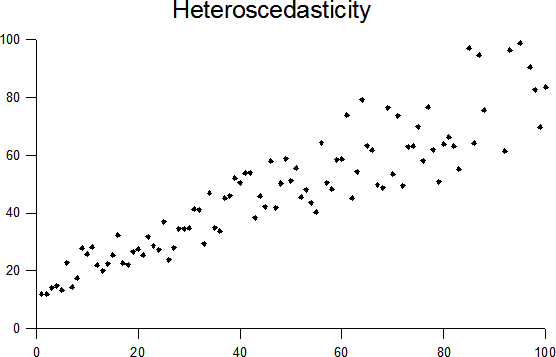



Testing for Homogeneity of Variance
Tests that you can run to check your data meets this assumption include:

Bartlett’s Test
Box’s M Test
Brown-Forsythe Test
Hartley’s Fmax test
Levene’s Test

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.levene.html
Scipy seems to contain these test

Homoskedasticity is one assumption of linear regression modeling. If the variance of the errors around the regression line varies much, the regression model may be poorly defined. The opposite of homoskedasticity is heteroskedasticity just as the opposite of "homogenous" is "heterogeneous." Heteroskedasticity (also spelled “heteroscedasticity”) refers to a condition in which the variance of the error term in a regression equation is not constant.
https://www.investopedia.com/terms/h/homoskedastic.asp

How to define the Error term when you do a linear regression:
Yi=aXi+b+Ei
Ei represents the error term and can be calculated as
Ei=Yi-(aXi+b) in other words
Ei=Yi-predicted(i)

In [ ]:
#Error (E)
E=aod550-predicted550
#Plot the error term against the value to predict aod550
fig=plt.figure(figsize=(40,30))
ax=fig.add_subplot(111)
ax.scatter(E,aod550)
ax.tick_params(axis='x', labelsize=70)
ax.tick_params(axis='y', labelsize=70)
ax.set_xlabel(r'$Error term$',fontsize=70)
ax.set_ylabel(r'aod550',fontsize=70)

In [ ]:
import scipy.stats as ss
# To sample my dataset I select area regarding to aod550 values
sample1=E[np.where(aod550<0.2)[0]] #0<aod550<0.2
sample2=E[np.where((aod550>0.2)&(aod550<0.4))[0]]#0.2<aod550<0.4
sample3=E[np.where((aod550>0.4)&(aod550<0.6))[0]]#0.4<aod550<0.6
sample4=E[np.where((aod550>0.6)&(aod550<0.8))[0]]#0.6<aod550<0.8

Levene=ss.levene(sample1,sample2,sample3,sample4)

In [ ]:
[np.var(s) for s in [sample1,sample2,sample3,sample4]]

Sample 6 has a small variance compared to the other but also has only 2 values in this sample

Apparently a pvalue over 0.05 means that the homoscedasticity hypothesis is verified


In [ ]:
Levene

# Copy the output back to the drive

In [ ]:
!mkdir /content/gdrive/'My Drive'/AERONET_V3/OUTPUTS

In [ ]:
!cp *.pdf /content/gdrive/'My Drive'/AERONET_V3/OUTPUTS
!cp *.txt /content/gdrive/'My Drive'/AERONET_V3/OUTPUTS
!cp *.nc /content/gdrive/'My Drive'/AERONET_V3/OUTPUTS